In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [8]:
def display_img(img, title="Image", cmap=None):
    plt.figure(figsize=(8, 6))
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
def detect_plate(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Lỗi: Không tìm thấy đường dẫn ảnh")
        return None, None
    
    img = cv2.resize(img, (640, 480))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)

    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
    gradX = cv2.GaussianBlur(gradX, (5, 5), 0)

    thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, rectKern)

    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        if 1.0 <= ar <= 6.0: 
            if w * h > 1000:
                plate_img = img[y:y+h, x:x+w].copy()
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                return img, plate_img
    
    print("Không tìm thấy biển số")
    return img, None

In [10]:
def sort_contours(cnts):
    if len(cnts) == 0: return []
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][0], reverse=False))
    return cnts

def segment_characters(plate_img):
    if plate_img is None: return None, []

    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (0,0), fx=2.0, fy=2.0) 
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    char_list = []
    vis_plate = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    if len(cnts) > 0:
        cnts = sort_contours(cnts)
        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            ratio = h / w
            height_ratio = h / gray.shape[0]

            if 0.4 < height_ratio < 0.95 and ratio > 0.3:
                char_roi = thresh[y:y+h, x:x+w]
                char_roi = cv2.resize(char_roi, (30, 60)) 
                char_list.append(char_roi)
                cv2.rectangle(vis_plate, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    return vis_plate, char_list

In [11]:
def get_hog_features(image):
    image = cv2.resize(image, (30, 60)) 
    hog = cv2.HOGDescriptor((30, 60), (10, 20), (5, 10), (5, 10), 9)
    h = hog.compute(image)
    return h.flatten()

dict_char_to_num = {
    'A': '4', 'B': '8', 'C': '0', 'D': '0', 'E': '8',
    'F': '5', 'G': '6', 'H': '8', 'I': '1', 'J': '3',
    'K': '4', 'L': '1', 'M': '4', 'N': '4', 'O': '0',
    'P': '9', 'Q': '0', 'R': '8', 'S': '5', 'T': '7',
    'U': '0', 'V': '7', 'W': '4', 'X': '4', 'Z': '2',
    'Y': '1' 
}
dict_num_to_char = {
    '4': 'A', '8': 'B', '0': 'D', '6': 'G', '5': 'S', 
    '2': 'Z', '1': 'I', '7': 'Z', '3': 'J', '9': 'P'
}


def check_D_G_pixel(char_img):

    h, w = char_img.shape
    roi = char_img[int(h*0.4):int(h*0.6), int(w*0.45):int(w*0.75)]
    if roi.size == 0: return 'D'
    white_pixels = cv2.countNonZero(roi)
    fill_ratio = white_pixels / roi.size
    return 'G' if fill_ratio > 0.35 else 'D'

def check_1_0_ratio(char_img):

    coords = cv2.findNonZero(char_img)
    if coords is None: return None
    x, y, w, h = cv2.boundingRect(coords)
    ratio = w / h
    if ratio < 0.4: return '1'
    if ratio > 0.55: return '0'
    return None

def check_1_7_morphology(char_img):
    coords = cv2.findNonZero(char_img)
    if coords is None: return '1'
    x, y, w, h = cv2.boundingRect(coords)

    roi = char_img[y:y+h, x:x+w]
    h_roi = roi.shape[0]

    if (w / h) < 0.28: return '1'

    roi_head = roi[0 : int(h_roi * 0.15), :]

    roi_waist = roi[int(h_roi * 0.4) : int(h_roi * 0.6), :]

    thick_head = cv2.countNonZero(roi_head) / roi_head.shape[0] if roi_head.shape[0] > 0 else 0
    thick_waist = cv2.countNonZero(roi_waist) / roi_waist.shape[0] if roi_waist.shape[0] > 0 else 0

    if thick_head > 1.8 * thick_waist:
        return '7'
        
    return '1'

def fix_label_strict(label, index, char_img_binary):
    label = str(label).upper()

    if index == 2:
        if label.isdigit():
            label = dict_num_to_char.get(label, 'A')
        if label in ['D', 'G', '0', 'O', 'Q']:
            return check_D_G_pixel(char_img_binary)
        return label

    else:
        if label.isalpha():
            label = dict_char_to_num.get(label, '1')

        if label in ['0', 'D', 'O', 'Q', '1', 'I', 'L']:
            check = check_1_0_ratio(char_img_binary)
            if check: label = check 

        if label in ['1', '7', 'I', 'T', 'J', 'Z']:
            return check_1_7_morphology(char_img_binary)

        return label

ready
Đang xử lý: ../3.jpg


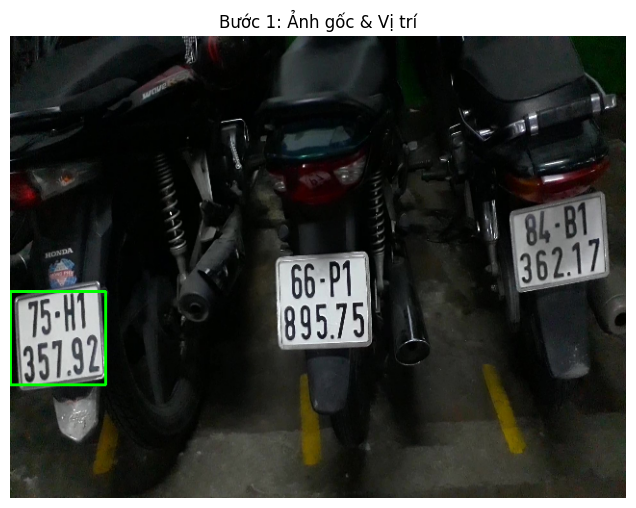

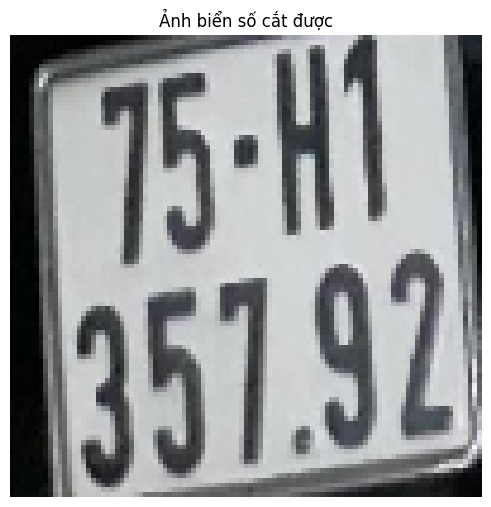

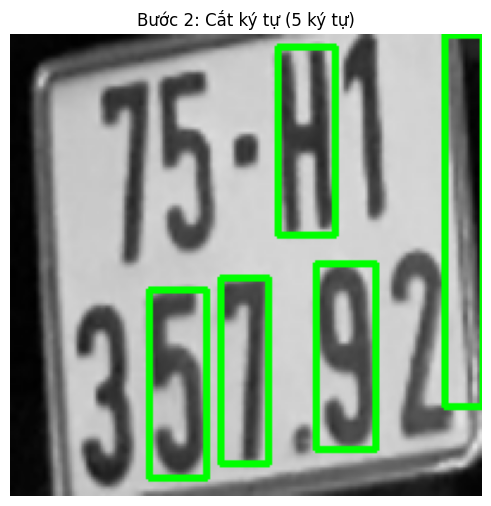

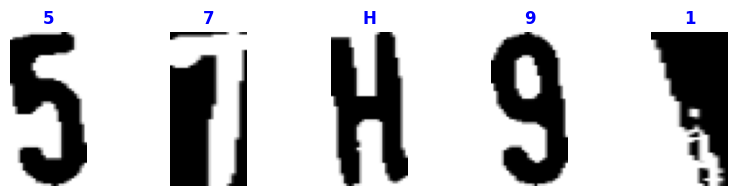


BIỂN SỐ XE LÀ: 57H91


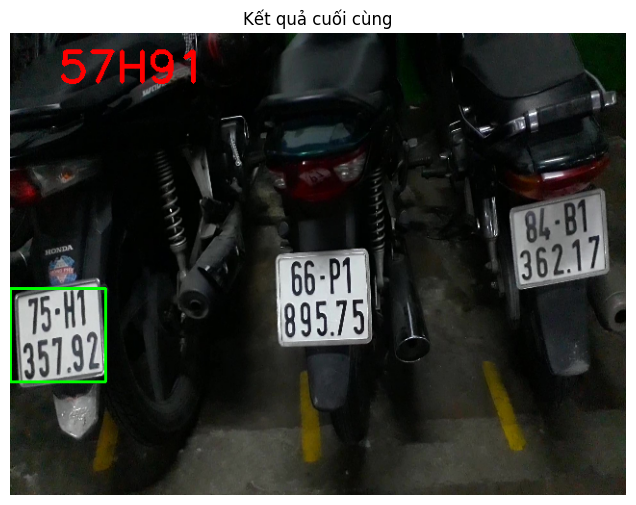

In [12]:
try:
    model = joblib.load('svm_license_plate.pkl') 
    print("ready")
except:
    print("error: Không tìm thấy file svm_license_plate.pkl")
    model = None

img_path = '../3.jpg'

print(f"Đang xử lý: {img_path}")

detected_img, plate_roi = detect_plate(img_path)

if plate_roi is not None:
    display_img(detected_img, "Bước 1: Ảnh gốc & Vị trí")
    display_img(plate_roi, "Ảnh biển số cắt được")
    
    plate_segmented, chars = segment_characters(plate_roi)
    display_img(plate_segmented, f"Bước 2: Cắt ký tự ({len(chars)} ký tự)")
    
    if model is not None and len(chars) > 0:
        plate_info = ""
        plt.figure(figsize=(10, 2))
        
        for i, char_img in enumerate(chars):
            if np.mean(char_img) > 127: char_img = cv2.bitwise_not(char_img)
            
            hog_feat = get_hog_features(char_img)
            result = model.predict([hog_feat])[0]
            
            try:
                val = int(result)
                if val > 9: raw_char = chr(val)
                else: raw_char = str(val)
            except:
                raw_char = str(result)
            
            final_char = fix_label_strict(raw_char, i, char_img)
            plate_info += final_char
            
            plt.subplot(1, len(chars), i+1)
            plt.imshow(char_img, cmap='gray')
            plt.title(f"{final_char}", fontsize=12, color='blue', fontweight='bold')
            plt.axis('off')
            
        plt.show()
        print(f"\nBIỂN SỐ XE LÀ: {plate_info}")
        
        cv2.putText(detected_img, plate_info, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        display_img(detected_img, "Kết quả cuối cùng")
else:
    print("Không tìm thấy biển số")